In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [ ]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import re
import networkx as nx

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
# from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
from analysis.dataframes2 import *
# from analysis.volumes import *
from helpers.ep_helpers import WallNormal
import math
from itertools import product
from analysis.cp_eq import calc_cp


sns.set_style("darkgrid")

In [8]:
cases = retrieve_cases()

In [9]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "red" in i.case_name]
case

CaseData(case_name='Medium_case_red_b1', idf=<geomeppy.idf.IDF object at 0x155df0760>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_red_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1'))

In [35]:
wind_dirs = [i*0.5 for i in range(721)]

In [36]:
def compute_incident_wind_dir_angle(wall_normal, wind_dir):
    res = wind_dir - wall_normal
    inc_angle = 360 - res if res > 180 else res # hmmm... 
    return inc_angle
    

In [12]:
from typing import NamedTuple

In [13]:
class AngleSurfacePair(NamedTuple):
    wall_normal: WallNormal
    wind_dir: float

class IncidentAngleData(NamedTuple):
    wall_normal_name: str
    wind_dir: float
    incident_angle: float

class CpData(IncidentAngleData):
    cp: float

In [37]:
angles_data =[ AngleSurfacePair(*j) for j in product([i for i in WallNormal], wind_dirs)]
incident_angles = [IncidentAngleData(i.wall_normal.name, i.wind_dir, compute_incident_wind_dir_angle(i.wall_normal.value, i.wind_dir)) for i in angles_data]
cps = [calc_cp(i.incident_angle) for i in incident_angles]
df = pl.DataFrame(data= {
    "wall_normal": [i.wall_normal_name for i in incident_angles],
    "wind_dir": [i.wind_dir for i in incident_angles],
    "incident_angle": [i.incident_angle for i in incident_angles],
    "cp": [calc_cp(i.incident_angle) for i in incident_angles]
})
df

wall_normal,wind_dir,incident_angle,cp
str,f64,f64,f64
"""NORTH""",0.0,0.0,0.603459
"""NORTH""",0.5,0.5,0.602762
"""NORTH""",1.0,1.0,0.602014
"""NORTH""",1.5,1.5,0.601218
"""NORTH""",2.0,2.0,0.600371
…,…,…,…
"""WEST""",358.0,88.0,-0.403689
"""WEST""",358.5,88.5,-0.413518
"""WEST""",359.0,89.0,-0.423296


In [15]:
# df = df.with_columns(adj_wind_dir=pl.when(pl.col("wind_dir") > 180).then(180 - pl.col("wind_dir") ).otherwise(pl.col("wind_dir") ))
# df.head()

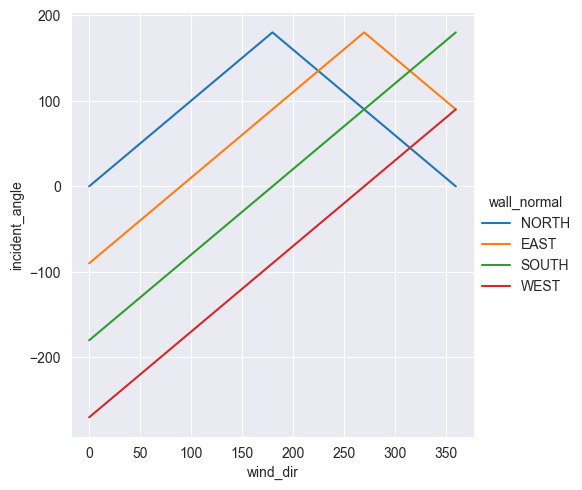

In [38]:
sns.relplot(df, x="wind_dir", y="incident_angle", hue="wall_normal", kind="line")

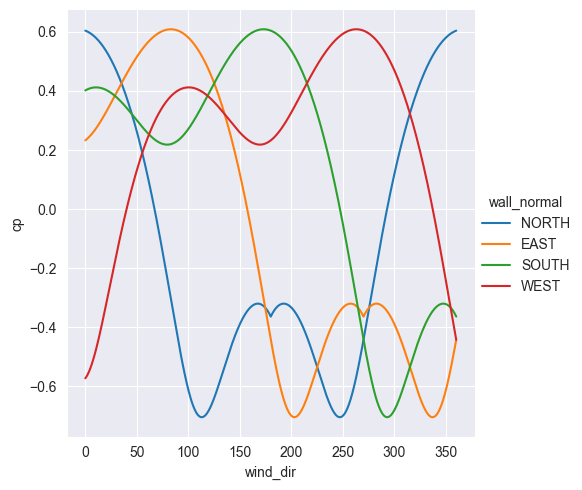

In [39]:
sns.relplot(df, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [40]:
df_pressure = get_external_node_df(case)
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg]
str,str,datetime[μs],f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:00:00,-0.201207,1.425,305.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:15:00,-0.19519,1.35,300.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:30:00,-0.164612,1.275,295.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:45:00,-0.137344,1.2,290.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 01:00:00,-0.126187,1.15,290.0
…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 22:45:00,-0.294717,1.8,310.0
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:00:00,-0.270799,1.725,310.0
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:15:00,-0.247882,1.65,310.0


In [41]:
df_pressure = df_pressure.with_columns(wind_val= 2/(pl.col("Site Wind Speed [m/s]"))**2)
df_pressure = df_pressure.with_columns(cp_val=pl.col("AFN Node Wind Pressure [Pa]")*pl.col("wind_val"))
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg],wind_val,cp_val
str,str,datetime[μs],f64,f64,f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:00:00,-0.201207,1.425,305.0,0.984918,-0.198173
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:15:00,-0.19519,1.35,300.0,1.097394,-0.214201
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:30:00,-0.164612,1.275,295.0,1.230296,-0.202522
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:45:00,-0.137344,1.2,290.0,1.388889,-0.190755
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 01:00:00,-0.126187,1.15,290.0,1.512287,-0.190831
…,…,…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 22:45:00,-0.294717,1.8,310.0,0.617284,-0.181924
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:00:00,-0.270799,1.725,310.0,0.672128,-0.182011
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:15:00,-0.247882,1.65,310.0,0.734619,-0.182099


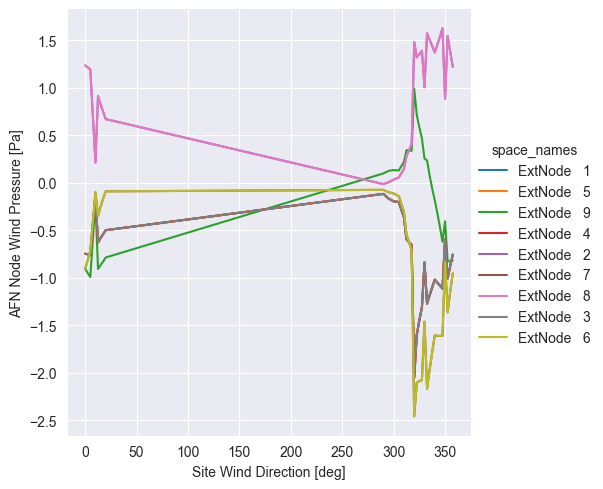

In [20]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="AFN Node Wind Pressure [Pa]", hue="space_names", kind="line", errorbar=None)

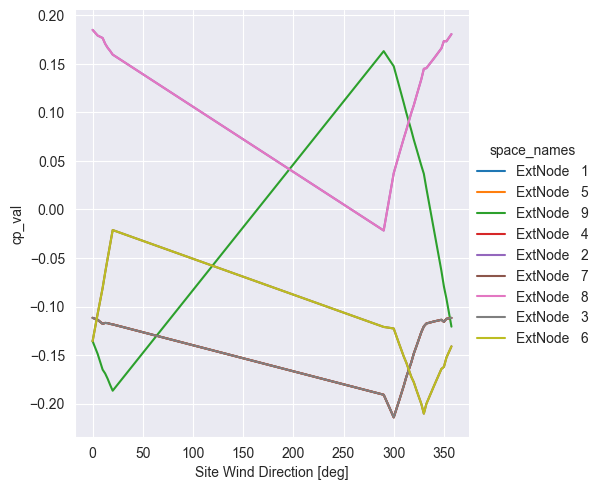

In [21]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="cp_val", hue="space_names", kind="line", errorbar=None)

In [45]:
exp_wind_dirs = list(df_pressure["Site Wind Direction [deg]"].unique())
len(exp_wind_dirs)

31

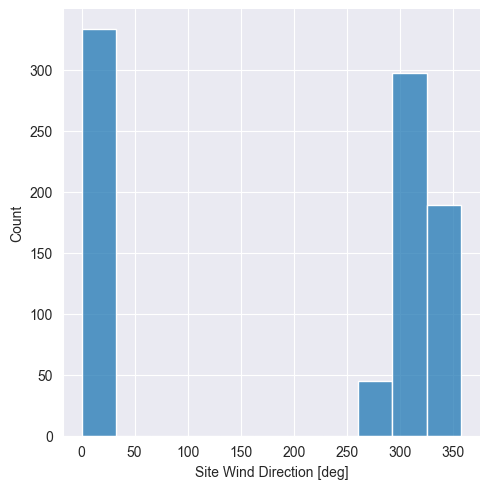

In [22]:
sns.displot(df_pressure, x="Site Wind Direction [deg]")

In [46]:
df_filtered = df.filter(pl.col("wind_dir").is_in(exp_wind_dirs))

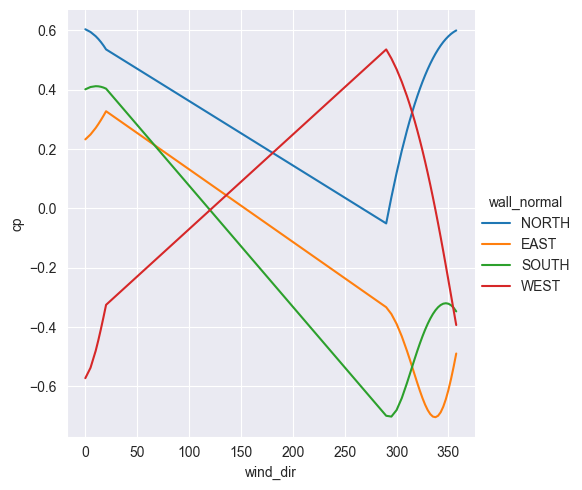

In [47]:
sns.relplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [55]:
df_an = df_filtered.pivot("wall_normal", index="wind_dir", values="cp")
df_an = df_an.rename({"wind_dir": "Site Wind Direction [deg]"})
df_an.head(2)

Site Wind Direction [deg],NORTH,EAST,SOUTH,WEST
f64,f64,f64,f64,f64
0.0,0.603459,0.23212,0.401005,-0.572971
5.0,0.594241,0.248685,0.40874,-0.537956


In [ ]:
df_exp = df_pressure.pivot("space_names", index=["datetimes", "Site Wind Direction [deg]"], values="cp_val",)
df_exp.head(2)

datetimes,Site Wind Direction [deg],ExtNode 3,ExtNode 2,ExtNode 8,ExtNode 7,ExtNode 9,ExtNode 4,ExtNode 1,ExtNode 6,ExtNode 5
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,305.0,-0.198173,0.055535,0.055535,-0.137395,0.128675,-0.198173,-0.198173,-0.137395,-0.198173
2017-07-01 00:15:00,300.0,-0.214201,0.037396,0.037396,-0.122679,0.147534,-0.214201,-0.214201,-0.122679,-0.214201


In [ ]:
def find_corr_pair(col_a, col_b):
    res = df_exp.select(pl.corr(col_a, col_b , method="spearman"))
    assert not (res[col_a].is_nan()).all()
    corr = res[col_a].to_list()[0]
    if corr == 1:
            return(col_a, col_b)
    return None

ext_cols = sorted(df_exp.select(cs.contains("Ext")).columns)
pairs = list(product(ext_cols, ext_cols))

corrs = [find_corr_pair(*p) for p in pairs]



In [ ]:
filtered_corrs = [tuple(sorted(i)) for i in corrs if i]
unique_corrs = list(set(filtered_corrs))
G=nx.from_edgelist(unique_corrs)
l=list(nx.connected_components(G))
independent_nodes = [list(i)[0] for i in l]
independent_nodes


In [131]:
df_ind = df_exp.select(["Site Wind Direction [deg]"] + independent_nodes)
df_ind.head()

Site Wind Direction [deg],ExtNode 3,ExtNode 7,ExtNode 2,ExtNode 9
f64,f64,f64,f64,f64
305.0,-0.198173,-0.137395,0.055535,0.128675
300.0,-0.214201,-0.122679,0.037396,0.147534
295.0,-0.202522,-0.121817,0.007972,0.155215
290.0,-0.190755,-0.120953,-0.021687,0.162961
290.0,-0.190831,-0.121001,-0.021696,0.163026


In [133]:
df_join = df_ind.join(df_an, on=["Site Wind Direction [deg]"])
df_join.head(2)
dir_cols = [i.name for i in WallNormal]

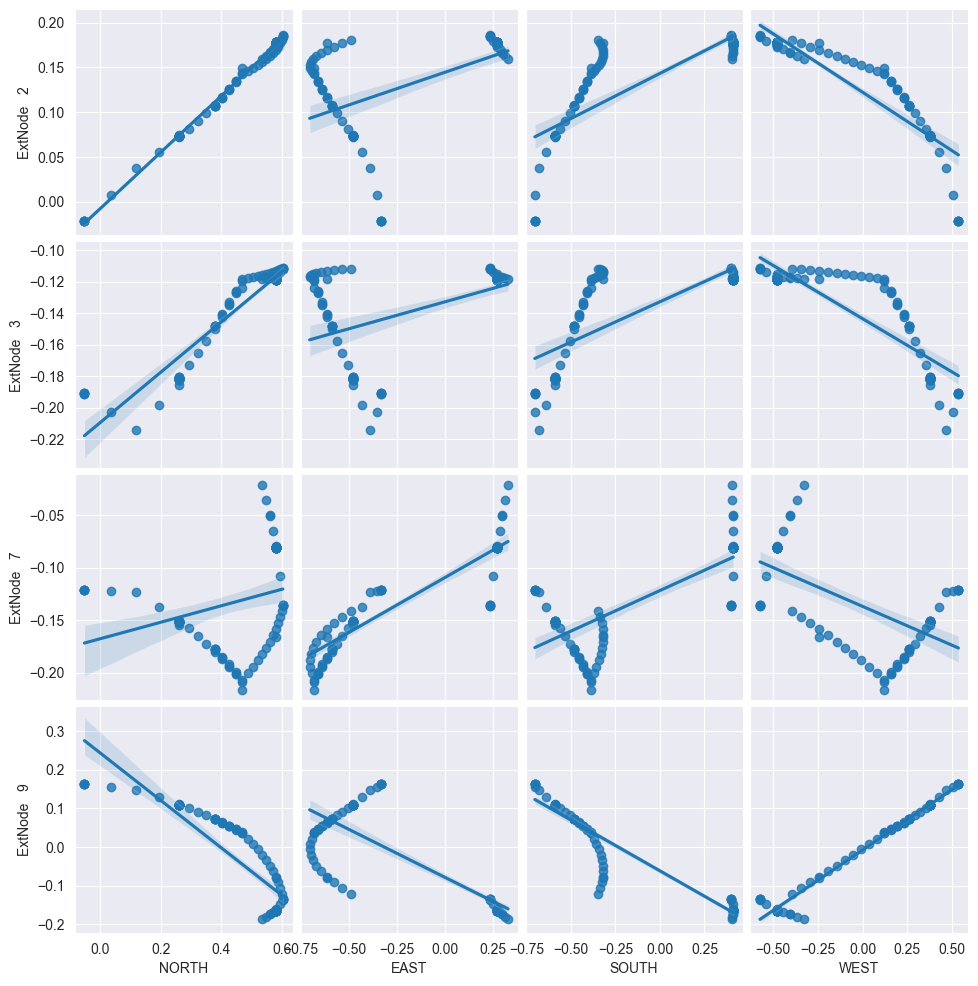

In [134]:
sns.pairplot(df_join.to_pandas(), x_vars=dir_cols, y_vars=ext_cols, kind="reg")